In [152]:
train_dir = "C:/Users/user/OneDrive/Desktop/New/data/train"
val_dir   = "C:/Users/user/OneDrive/Desktop/New/data/val"
test_dir = "C:/Users/user/OneDrive/Desktop/New/data/test"

In [98]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, 
        width_shift_range=0.1, height_shift_range=0.1)

train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(28,28),
        batch_size=1,
        class_mode='sparse',shuffle = False)

validation_generator = train_datagen.flow_from_directory(
        val_dir,  
        target_size=(28,28),  
        class_mode='sparse',shuffle = False)

test_generator = train_datagen.flow_from_directory(
        test_dir,
        target_size=(28,28),  
        class_mode='sparse',shuffle = False)

Found 936 images belonging to 36 classes.
Found 216 images belonging to 36 classes.
Found 360 images belonging to 36 classes.


In [68]:
labels = list(train_generator.class_indices.keys())
print(labels)

['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9', 'class_A', 'class_B', 'class_C', 'class_D', 'class_E', 'class_F', 'class_G', 'class_H', 'class_I', 'class_J', 'class_K', 'class_L', 'class_M', 'class_N', 'class_O', 'class_P', 'class_Q', 'class_R', 'class_S', 'class_T', 'class_U', 'class_V', 'class_W', 'class_X', 'class_Y', 'class_Z']


In [69]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

In [70]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 16)        23248     
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        131104    
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        131136    
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        65600     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                      

In [71]:
# Metrics for checking the model performance while training
def f1score(y, y_pred):
  return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro') 

def custom_f1score(y, y_pred):
  return tf.py_function(f1score, (y, y_pred), tf.double)
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=0.0001), 
              metrics=[custom_f1score])

In [72]:
class stop_training_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_custom_f1score') > 0.99):
      self.model.stop_training = True

In [73]:
batch_size = 1
callbacks = [stop_training_callback()]
model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 80, verbose=1, callbacks=callbacks)

Epoch 1/80
936/936 [==============================] - 34s 36ms/step - loss: 3.1019 - custom_f1score: 0.1645 - val_loss: 2.0963 - val_custom_f1score: 0.3780
Epoch 2/80
936/936 [==============================] - 34s 36ms/step - loss: 1.5340 - custom_f1score: 0.5481 - val_loss: 0.9412 - val_custom_f1score: 0.7277
Epoch 3/80
936/936 [==============================] - 34s 36ms/step - loss: 0.7518 - custom_f1score: 0.7585 - val_loss: 0.6055 - val_custom_f1score: 0.8318
Epoch 4/80
936/936 [==============================] - 34s 36ms/step - loss: 0.4864 - custom_f1score: 0.8408 - val_loss: 0.4468 - val_custom_f1score: 0.8676
Epoch 5/80
936/936 [==============================] - 34s 36ms/step - loss: 0.3954 - custom_f1score: 0.8750 - val_loss: 0.3523 - val_custom_f1score: 0.9033
Epoch 6/80
936/936 [==============================] - 34s 36ms/step - loss: 0.3041 - custom_f1score: 0.9028 - val_loss: 0.1282 - val_custom_f1score: 0.9673
Epoch 7/80
936/936 [==============================] - 34s 36ms/s

In [74]:
loss, acc = model.evaluate(train_generator, steps=train_generator.n//batch_size)
print("The accuracy of the model is {:.3f}\nThe Loss in the model is {:.3f}".format(acc,loss))

936/936 [==============================] - 7s 7ms/step - loss: 0.0526 - custom_f1score: 0.9776
The accuracy of the model is 0.978
The Loss in the model is 0.053


In [188]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

preds=model.predict(validation_generator)

In [189]:
preds

array([[7.6061571e-01, 2.7106029e-05, 9.6887889e-06, ..., 1.2183587e-05,
        1.5332422e-04, 1.1361237e-05],
       [7.0801169e-01, 3.8088368e-05, 1.2135729e-05, ..., 4.0910535e-07,
        6.4787033e-05, 1.5074745e-06],
       [9.1151792e-01, 1.5799735e-05, 2.3294588e-06, ..., 5.4030911e-06,
        3.7847702e-05, 3.6965018e-06],
       ...,
       [1.3910890e-11, 1.1650154e-10, 3.2748377e-03, ..., 1.9989452e-07,
        5.3495006e-07, 9.9618405e-01],
       [1.8983659e-09, 3.9493314e-10, 2.2046100e-03, ..., 7.0236062e-08,
        1.9352733e-06, 9.6450394e-01],
       [4.1988272e-13, 1.6475272e-13, 7.0215217e-05, ..., 1.1371328e-09,
        6.2702119e-09, 9.9992490e-01]], dtype=float32)

In [190]:
y_pred = np.argmax(preds,axis=1)
y_pred

array([ 0,  0,  0,  0, 24,  0,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,
        2,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
        5,  5,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  8,  8,  8,
        8,  8,  8,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 11, 11,
       11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 14,
       14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19,
       29, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 15, 22, 22, 22,
       22, 22, 23, 23, 23, 23, 23, 23, 24, 24,  0,  0, 24, 24, 25, 25, 25,
       25, 25, 25, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 28, 28,
       28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 31,
       31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33,
       34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35], dtype=int64)

In [191]:
y_actual = validation_generator.classes
y_actual

array([ 0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,
        2,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
        5,  5,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  8,  8,  8,
        8,  8,  8,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 11, 11,
       11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 14,
       14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19,
       19, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22,
       22, 22, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 25, 25, 25,
       25, 25, 25, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 28, 28,
       28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 31,
       31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33,
       34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35])

In [130]:
l = list(train_generator.class_indices.keys())
print(l)

['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9', 'class_A', 'class_B', 'class_C', 'class_D', 'class_E', 'class_F', 'class_G', 'class_H', 'class_I', 'class_J', 'class_K', 'class_L', 'class_M', 'class_N', 'class_O', 'class_P', 'class_Q', 'class_R', 'class_S', 'class_T', 'class_U', 'class_V', 'class_W', 'class_X', 'class_Y', 'class_Z']


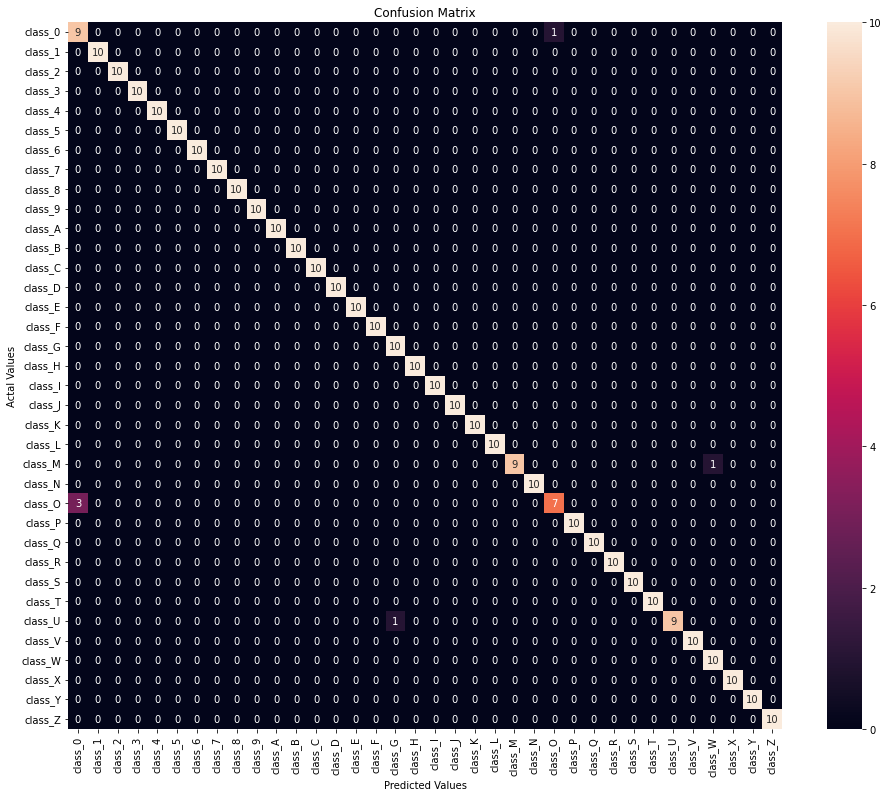

In [141]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import seaborn as sns
cm = confusion_matrix(y_actual, y_pred)

cm_df = pd.DataFrame(cm,
                     index = l, 
                     columns = l)
plt.figure(figsize=(16,13))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=l)
# f = plt.figure()
# disp.plot()
# plt.show()

In [192]:
print(classification_report(y_true=y_actual, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.71      0.83      0.77         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         6
           7       1.00      1.00      1.00         6
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00         6
          10       1.00      1.00      1.00         6
          11       1.00      1.00      1.00         6
          12       1.00      1.00      1.00         6
          13       1.00      1.00      1.00         6
          14       1.00      1.00      1.00         6
          15       0.86      1.00      0.92         6
          16       1.00      1.00      1.00         6
          17       1.00    

In [167]:
from tensorflow import keras
test_dir = "C:/Users/user/OneDrive/Desktop/New/data/test"
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, 
        width_shift_range=0.1, height_shift_range=0.1)
test_generator = train_datagen.flow_from_directory(
        test_dir,
        target_size=(28,28),  
        class_mode='sparse',shuffle = False)
# image = tf.keras.preprocessing.image.load_img('C:/Users/user/OneDrive/Desktop/New/data/test/class_0')
# img_array = keras.preprocessing.image.img_to_array(image)
# input_arr = np.array([input_arr])


Found 360 images belonging to 36 classes.


In [170]:
len(test_generator)

12

In [174]:
img = keras.preprocessing.image.load_img(
    'C:/Users/user/OneDrive/Desktop/New/data/test/class_0/class_0_13.jpg', target_size=(28,28)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

In [175]:
img_array

<tf.Tensor: shape=(1, 28, 28, 3), dtype=float32, numpy=
array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [3., 3., 3.],
         ...,
         [1., 1., 1.],
         [0., 0., 0.],
         [1., 1., 1.]],

        [[2., 2., 2.],
         [1., 1., 1.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [1., 1., 1.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [2., 2., 2.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[1., 1., 1.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]], dtype

In [178]:
from time import perf_counter
t_time = 0
for i in range(0,100):
    time_start = perf_counter()
    predictions = model.predict(img_array)
    time_end = perf_counter()
    t_time = t_time + (time_end - time_start)*1000
print(t_time/100)

36.83435700004338


In [197]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'C:/Users/user/OneDrive/Desktop/New/data/test',
  image_size=(28,28),shuffle = False)

Found 360 files belonging to 36 classes.


In [202]:
score = model.evaluate(test_ds, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9817708134651184


In [200]:
time_start = perf_counter()
Y_pred = model.predict(test_ds)
time_end = perf_counter()
print((time_end - time_start)/360)

0.002921558611099802
